<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/solutions/Benchmark_models_and_bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

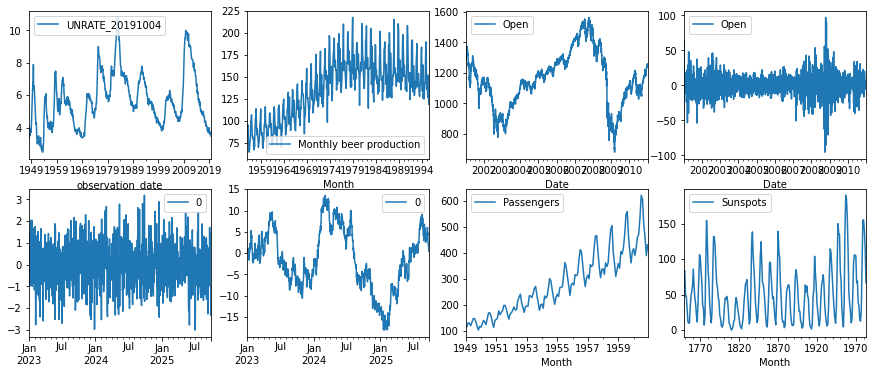

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

df_uschange = pd.read_csv('https://raw.githubusercontent.com/robjhyndman/fpp3package/master/data-raw/US_change/uschange_fpp3_Monthly.txt', delimiter='\t', index_col='observation_date')
df_uschange.index = pd.DatetimeIndex(df_uschange.index)

df_beer = pd.read_csv('https://raw.githubusercontent.com/ejgao/Time-Series-Datasets/master/monthly-beer-production-in-austr.csv', index_col='Month', parse_dates=True)
df_beer.index = pd.DatetimeIndex(df_beer.index)

df_goog = pd.read_csv('https://raw.githubusercontent.com/bharatpurohit97/StockPrediction/master/ReinforcementLearning-YahooFinance/data/%5EGSPC.csv', index_col='Date', parse_dates=True)[['Open']]
df_goog.index = pd.DatetimeIndex(df_goog.index)
df_goog = df_goog.resample('1d').mean().interpolate('linear')

df_air = pd.read_csv('https://raw.githubusercontent.com/Manishms18/Air-Passengers-Time-Series-Analysis/master/Data/AirPassengers.csv', index_col='Month', parse_dates=True)

df_sun = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv', index_col='Month', parse_dates=True)
df_sun.index = pd.DatetimeIndex(df_sun.index)
df_sun = df_sun.resample('y').mean()
df_sun = df_sun.interpolate('linear')

n = 1000
df_rn = pd.DataFrame(np.random.randn(n), index=pd.date_range('2023', periods=n))
df_rw = pd.DataFrame(np.cumsum(np.random.randn(n)), index=pd.date_range('2023', periods=n))

dfs = [df_uschange, df_beer, df_goog, df_goog.diff().iloc[1:], df_rn, df_rw, df_air, df_sun]
names = ['uschange', 'beer', 'goog', 'goog diff', 'RN', 'RW', 'air', 'sunspots']

fig, ax = plt.subplots(2, 4, figsize=(15, 6))
for a, df in zip(ax.ravel(), dfs):
    df.plot(ax=a)

In [2]:
p = 12
mean = lambda x, h: pd.DataFrame(np.tile(x.mean(), h), index=x.index[-1]+np.arange(1, 1+h), columns=x.columns)
seasonal = lambda x, h: pd.DataFrame(np.tile(x.iloc[-p:].values.ravel(), int(p*np.ceil(h/p)))[:h], index=x.index[-1]+np.arange(1, 1+h), columns=x.columns)
naive = lambda x, h: pd.DataFrame(np.tile(x.iloc[-1], h), index=x.index[-1]+np.arange(1, 1+h), columns=x.columns)
forecasters = [naive, mean, seasonal]
forecasters_names = ['naive', 'mean', 'seasonal']

In [10]:
def get_errs(df_tr, forecaster, steps_ahead):
  errs = {}
  df_tr.reset_index(drop=True, inplace=True)
  for i in np.arange(1, len(df_tr)-steps_ahead):
    y_hat = forecaster(df_tr.iloc[:i], steps_ahead)
    err = df_tr.iloc[i:i+steps_ahead] - y_hat
    errs[df_tr.index[i]] = err.values.ravel()
  return pd.DataFrame(errs).T

errs = get_errs(df, naive, 3)
errs.head(5)

,0,1,2
1,2.466667,-33.266667,-33.125000
2,-35.733333,-35.591667,-52.700000
3,0.141667,-16.966667,-35.441667
4,-17.108333,-35.583333,-38.233333
5,-18.475000,-21.125000,-20.500000


retrieving errs naive on dataset uschange
retrieving errs mean on dataset uschange
retrieving errs seasonal on dataset uschange
retrieving errs naive on dataset beer
retrieving errs mean on dataset beer
retrieving errs seasonal on dataset beer
retrieving errs naive on dataset goog
retrieving errs mean on dataset goog
retrieving errs seasonal on dataset goog
retrieving errs naive on dataset goog diff
retrieving errs mean on dataset goog diff
retrieving errs seasonal on dataset goog diff
retrieving errs naive on dataset RN
retrieving errs mean on dataset RN
retrieving errs seasonal on dataset RN
retrieving errs naive on dataset RW
retrieving errs mean on dataset RW
retrieving errs seasonal on dataset RW
retrieving errs naive on dataset air
retrieving errs mean on dataset air
retrieving errs seasonal on dataset air
retrieving errs naive on dataset sunspots
retrieving errs mean on dataset sunspots
retrieving errs seasonal on dataset sunspots
standard deviations of the errors for step 0:
us

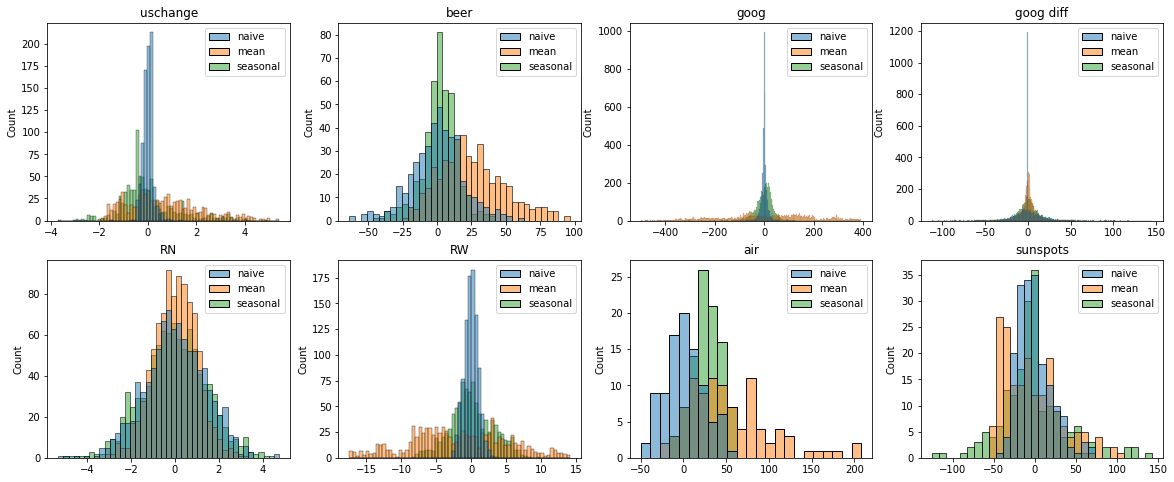

In [13]:
def get_all_errs(dfs, names, forecasters, forecasters_names,steps_ahead=1, test_samples=48, do_plots=True):
  if do_plots:
    fig, ax = plt.subplots(2, 4, figsize=(20, 8))
  stds = {}
  all_errs = {}
  for df, name, a in zip(dfs, names, ax.ravel()):
      errs = {}
      for f, f_name in zip(forecasters, forecasters_names):
          print('retrieving errs {} on dataset {}'.format(f_name, name))
          df_tr = df.iloc[:-test_samples]
          errs[f_name] = get_errs(df_tr, f, steps_ahead)
      all_errs[name] = pd.concat(errs,axis=1)
      stds[name] = all_errs[name].std()
      if do_plots:
        sb.histplot(all_errs[name], ax=a)
        a.set_title(name)
  return all_errs, stds
all_errs, stds = get_all_errs(dfs, names, forecasters, forecasters_names, steps_ahead=1, test_samples=48, do_plots=True)
stds = pd.concat(stds)
print('standard deviations of the errors for step 0:')
print(stds)

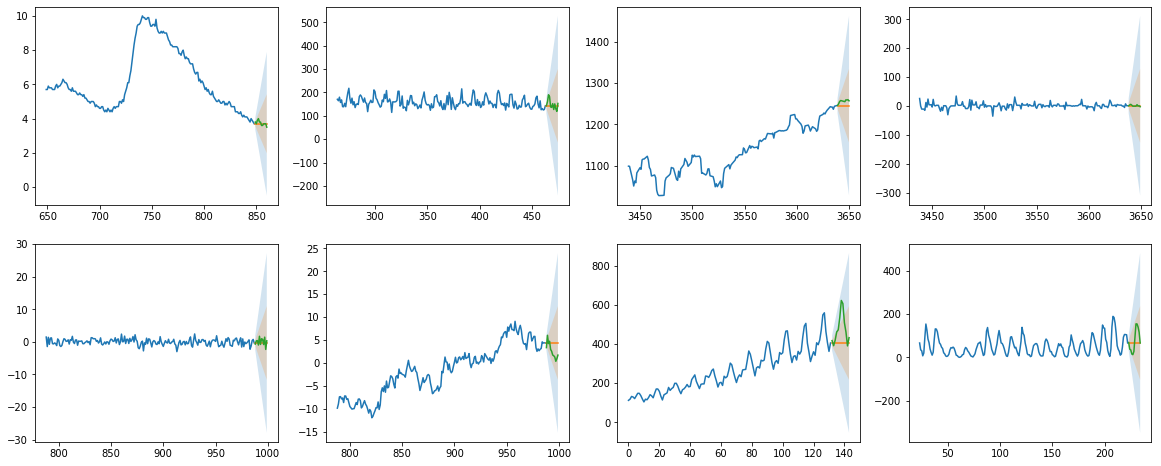

In [14]:

from scipy.stats import norm
get_ci = lambda y, std, alpha: pd.DataFrame(y.values + np.outer((std*np.arange(1, len(y)+1)*norm.ppf((1-alpha)/2 + alpha)), np.array([1, -1])),index=y.index)

steps_ahead = 12
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for a, df, n in zip(ax.ravel(), dfs, names):
    df.reset_index(drop=True, inplace=True)
    df_tr, df_te = df.iloc[:-steps_ahead], df.iloc[-steps_ahead:]
    y_hat = naive(df_tr, steps_ahead)
    std = stds[n]['naive'].values
    cis_90 = get_ci(y_hat, std, 0.9)
    cis_50 = get_ci(y_hat, std, 0.5)
    a.plot(df_tr.iloc[-200:])
    a.plot(y_hat)
    a.plot(df_te)
    a.fill_between(cis_90.index, *cis_90.values.T, alpha=0.2)
    a.fill_between(cis_80.index, *cis_80.values.T, alpha=0.2)


retrieving errs naive on dataset uschange
retrieving errs naive on dataset beer
retrieving errs naive on dataset goog
retrieving errs naive on dataset goog diff
retrieving errs naive on dataset RN
retrieving errs naive on dataset RW
retrieving errs naive on dataset air
retrieving errs naive on dataset sunspots


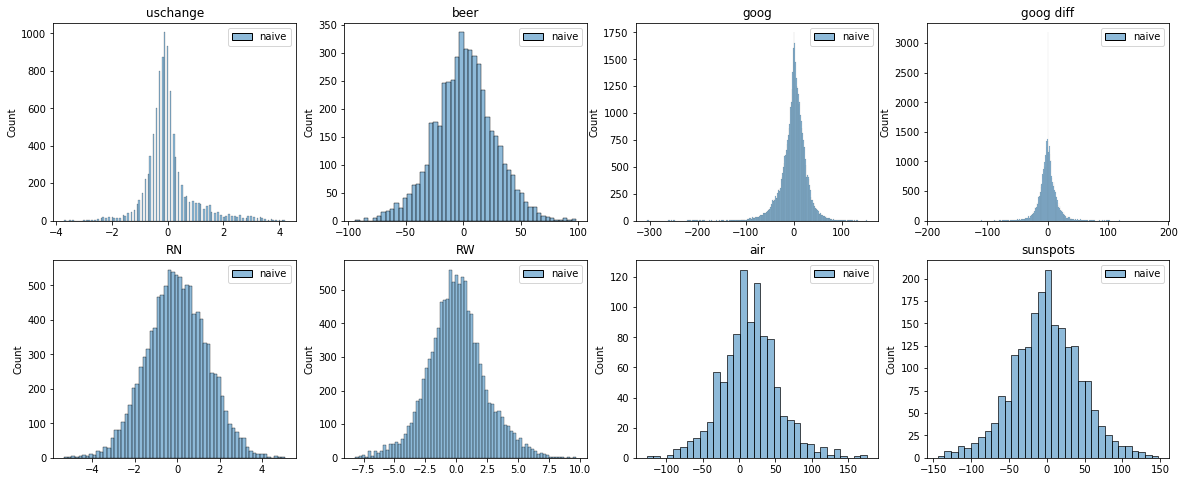

In [15]:
all_errs, stds = get_all_errs(dfs, names, [naive],['naive'], steps_ahead=steps_ahead, test_samples=48, do_plots=True)


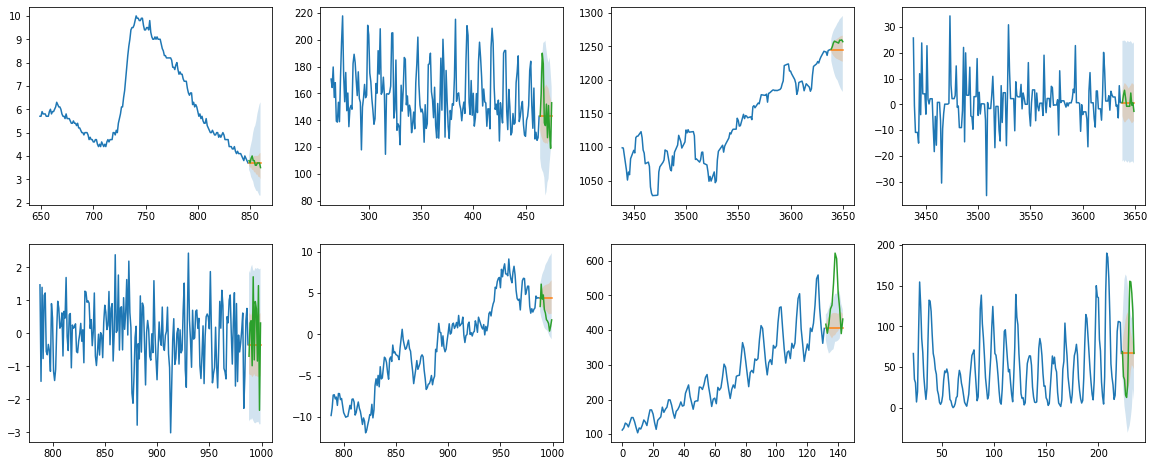

In [26]:
steps_ahead = 12
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for a, df, n in zip(ax.ravel(), dfs, names):
    df.reset_index(drop=True, inplace=True)
    df_tr, df_te = df.iloc[:-steps_ahead], df.iloc[-steps_ahead:]
    y_hat = naive(df_tr, steps_ahead)
    cis_90 = np.quantile(all_errs[n],[0.05, 0.95], axis=0) + y_hat.values.ravel()
    cis_50 = np.quantile(all_errs[n],[0.25, 0.75], axis=0)+ y_hat.values.ravel()
    a.plot(df_tr.iloc[-200:])
    a.plot(y_hat)
    a.plot(df_te)
    a.fill_between(y_hat.index, *cis_90, alpha=0.2)
    a.fill_between(y_hat.index, *cis_50, alpha=0.2)